# Behaviour Tree

More information on: [Documentation](https://py-trees.readthedocs.io/en/devel/) and [Github](https://github.com/splintered-reality/py_trees/blob/devel/README.md)

<center>
<img src="img/sample_tree.webp" width="400"/>
</center>

## Behaviours (Action Node)

A Behaviour is the smallest element in a behaviour tree, i.e. it is the leaf. Behaviours are usually representative of either a check (am I hungry?), or an action (buy some chocolate cookies).


<center>
<img src="img/leaf.png" />
</center>

## Type of composites (Control Nodes):

<center>
<img src="img/composites.png" width="500"/>
</center>


- [Selector](https://py-trees.readthedocs.io/en/devel/composites.html#selector): execute a child based on cascading priorities
- [Sequence](https://py-trees.readthedocs.io/en/devel/composites.html#sequence): execute children sequentially
- [Parallel](https://py-trees.readthedocs.io/en/devel/composites.html#parallel): execute children concurrently


### Selector

A selector is a composite node that ticks each child in order until one of them returns success. As soon as a child succeeds, the selector stops and returns success; if none do, it returns failure.

### Sequence

A sequence ticks its children one after the other. If any child fails, the sequence immediately stops and returns failure; only if all children succeed does it return success.


### Parallel

A parallel composite ticks all its children concurrently. Its outcome is determined by configurable thresholds: it returns success if enough children succeed, and failure if too many fail.

[Policies](https://py-trees.readthedocs.io/en/devel/modules.html#py_trees.common.ParallelPolicy): 
- SuccessOnAll
- SuccessOnOne
- SuccessOnSelected

## Blackbaord (BB) - the data store

[Blackboards](https://py-trees.readthedocs.io/en/devel/blackboards.html#), for behaviours to write and read from.

Blackboards are not a necessary component of behaviour tree implementations, but are nonetheless, a fairly common mechanism for sharing data between behaviours in the tree

# Getting Started

In [32]:

# Install py_trees
%pip install py_trees

# For visualization
%pip install pydot

# Note: You'll need graphviz installed on your system for visualization

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import py_trees
import time

# for visualization
from IPython.display import Image, display

In [34]:
# Helper functions 

# to draw the behaviour tree
def draw_tree(root: py_trees.trees.BehaviourTree):
    img = py_trees.display.render_dot_tree(root)
    display(Image(data=img["png"]))

# print an asci tree 
def print_tree(tree: py_trees.trees.BehaviourTree) -> None:
    """Print the behaviour tree and its current status."""
    print(py_trees.display.unicode_tree(root=tree.root, show_status=True))

## Simple Tree with one Leaf Node

[ INFO] AlwaysSuccess        : Always returning SUCCESS
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.dot
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.png
Writing /home/andri/repos/getting_started_py_tree/alwayssuccess.svg


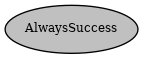

In [35]:
# Create a simple behavior that always succeeds
class AlwaysSuccess(py_trees.behaviour.Behaviour):
    def __init__(self, name="AlwaysSuccess"):
        super(AlwaysSuccess, self).__init__(name)
    
    def update(self):
        # This behavior always returns SUCCESS
        self.logger.info("Always returning SUCCESS")
        return py_trees.common.Status.SUCCESS

# Create an instance of our behavior
always_success = AlwaysSuccess()

# Set up the tree
root = always_success

# Create and setup the behavior tree
behavior_tree = py_trees.trees.BehaviourTree(root)

# Execute the tree once
behavior_tree.tick()

draw_tree(root)

## Selector Examples

Writing /home/andri/repos/getting_started_py_tree/root_selector.dot
Writing /home/andri/repos/getting_started_py_tree/root_selector.png
Writing /home/andri/repos/getting_started_py_tree/root_selector.svg


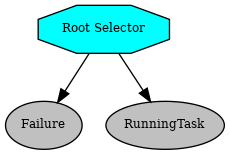

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 2.00 seconds remaining
[o] Root Selector [*]
    --> Failure [✕]
    --> RunningTask [*]

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 1.50 seconds remaining
[o] Root Selector [*]
    --> Failure [✕]
    --> RunningTask [*]

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 1.00 seconds remaining
[o] Root Selector [*]
    --> Failure [✕]
    --> RunningTask [*]

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Still running, 0.50 seconds remaining
[o] Root Selector [*]
    --> Failure [✕]
    --> RunningTask [*]

[ INFO] Failure              : Always returning FAILURE
[ INFO] RunningTask          : Finished running, returning SUCCESS
[o] Root Selector [✓]
    --> Failure [✕]
    --> RunningTask [✓]



In [36]:
# A behavior that always fails
class AlwaysFail(py_trees.behaviour.Behaviour):
    def __init__(self, name="AlwaysFail"):
        super(AlwaysFail, self).__init__(name)
    
    def update(self):
        self.logger.info("Always returning FAILURE")
        return py_trees.common.Status.FAILURE

# A behavior that runs for a while before succeeding
class RunningThenSuccess(py_trees.behaviour.Behaviour):
    def __init__(self, name="RunningThenSuccess", duration=3):
        super(RunningThenSuccess, self).__init__(name)
        self.duration = duration
        self.start_time = None

    def initialise(self):
        self.start_time = time.time()
    
    def update(self):
        if time.time() - self.start_time > self.duration:
            self.logger.info("Finished running, returning SUCCESS")
            return py_trees.common.Status.SUCCESS
        else:
            remaining = self.duration - (time.time() - self.start_time)
            self.logger.info(f"Still running, {remaining:.2f} seconds remaining")
            return py_trees.common.Status.RUNNING

# Create instances
always_fail = AlwaysFail("Failure")
running_then_success = RunningThenSuccess("RunningTask", 2)

# Try to use a Sequence instead of a Selector
root = py_trees.composites.Selector("Root Selector", memory=False)
#root = py_trees.composites.Sequence("Root Selector", memory=False)

root.add_children([always_fail, running_then_success])

# Create and setup the behavior tree
behaviour_tree = py_trees.trees.BehaviourTree(root=root)

draw_tree(root)

try:
    behaviour_tree.tick_tock(
        period_ms=500,
        #number_of_iterations=py_trees.trees.CONTINUOUS_TICK_TOCK,
        number_of_iterations=5,
        pre_tick_handler=None,
        post_tick_handler=print_tree,
    )

except KeyboardInterrupt:
    behaviour_tree.interrupt()

[o] Selector
    --> High Priority
    --> Med Priority
    --> Low Priority

Writing /home/andri/repos/getting_started_py_tree/selector.dot
Writing /home/andri/repos/getting_started_py_tree/selector.png
Writing /home/andri/repos/getting_started_py_tree/selector.svg


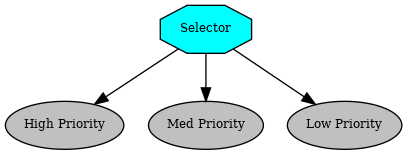

[o] Selector [✓]
    --> High Priority [✕] -- failure
    --> Med Priority [✓] -- success
    --> Low Priority [-]

[o] Selector [✓]
    --> High Priority [✕] -- failure
    --> Med Priority [✓] -- success
    --> Low Priority [-]

[o] Selector [✓]
    --> High Priority [✕] -- failure
    --> Med Priority [✓] -- success
    --> Low Priority [-]

[o] Selector [✓]
    --> High Priority [✕] -- failure
    --> Med Priority [✓] -- success
    --> Low Priority [-]

[o] Selector [✓]
    --> High Priority [✕] -- failure
    --> Med Priority [✓] -- success
    --> Low Priority [-]



In [37]:
root = py_trees.composites.Selector("Selector", memory=False)
s1 = py_trees.behaviours.Failure(name="High Priority")
s2 = py_trees.behaviours.Success(name="Med Priority")
s3 = py_trees.behaviours.Success(name="Low Priority")

root.add_children([s1, s2, s3])

behaviour_tree = py_trees.trees.BehaviourTree(root=root)

print(py_trees.display.unicode_tree(root=root))

behaviour_tree.setup(timeout=15)
draw_tree(root)

try:
    behaviour_tree.tick_tock(
        period_ms=500,
        number_of_iterations=5,
        pre_tick_handler=None,
        post_tick_handler=print_tree,
    )

except KeyboardInterrupt:
    behaviour_tree.interrupt()

## Sequence Example

To get a beer from the fridge, each task must succeed. Try what happens when the door open task returns Failure.

[-] Selector
    --> Open Door
    --> Get Beer
    --> Close Door

Writing /home/andri/repos/getting_started_py_tree/selector.dot
Writing /home/andri/repos/getting_started_py_tree/selector.png
Writing /home/andri/repos/getting_started_py_tree/selector.svg


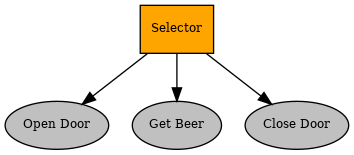

[-] Selector [✓]
    --> Open Door [✓] -- success
    --> Get Beer [✓] -- success
    --> Close Door [✓] -- success

[-] Selector [✓]
    --> Open Door [✓] -- success
    --> Get Beer [✓] -- success
    --> Close Door [✓] -- success

[-] Selector [✓]
    --> Open Door [✓] -- success
    --> Get Beer [✓] -- success
    --> Close Door [✓] -- success



In [38]:
root = py_trees.composites.Sequence("Selector", memory=False)
s1 = py_trees.behaviours.Success(name="Open Door")
#open = py_trees.behaviours.Failure(name="Open Door")
s2 = py_trees.behaviours.Success(name="Get Beer")
s3 = py_trees.behaviours.Success(name="Close Door")

root.add_children([s1, s2, s3])

behaviour_tree = py_trees.trees.BehaviourTree(root=root)

print(py_trees.display.unicode_tree(root=root))

behaviour_tree.setup(timeout=15)
draw_tree(root)

try:
    behaviour_tree.tick_tock(
        period_ms=500,
        number_of_iterations=3,
        pre_tick_handler=None,
        post_tick_handler=print_tree,
    )

except KeyboardInterrupt:
    behaviour_tree.interrupt()

## Parallel Example

/_/ Selector
    --> Read Sensor 1
    --> Read Sensor 2
    --> Read Sensor 3

Writing /home/andri/repos/getting_started_py_tree/selector.dot
Writing /home/andri/repos/getting_started_py_tree/selector.png
Writing /home/andri/repos/getting_started_py_tree/selector.svg


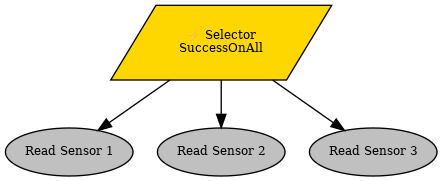

/_/ Selector [*]
    --> Read Sensor 1 [✓] -- success
    --> Read Sensor 2 [*] -- running
    --> Read Sensor 3 [✓] -- success

/_/ Selector [*]
    --> Read Sensor 1 [✓] -- success
    --> Read Sensor 2 [*] -- running
    --> Read Sensor 3 [✓] -- success

/_/ Selector [*]
    --> Read Sensor 1 [✓] -- success
    --> Read Sensor 2 [*] -- running
    --> Read Sensor 3 [✓] -- success



In [39]:
root = py_trees.composites.Parallel("Selector", policy=py_trees.common.ParallelPolicy.SuccessOnAll())
s1 = py_trees.behaviours.Success(name="Read Sensor 1")
#s1 = py_trees.behaviours.Failure(name="Open Door")
s2 = py_trees.behaviours.Running(name="Read Sensor 2")
s3 = py_trees.behaviours.Success(name="Read Sensor 3")

root.add_children([s1, s2, s3])

behaviour_tree = py_trees.trees.BehaviourTree(root=root)

print(py_trees.display.unicode_tree(root=root))

behaviour_tree.setup(timeout=15)
draw_tree(root)

try:
    behaviour_tree.tick_tock(
        period_ms=500,
        number_of_iterations=3,
        pre_tick_handler=None,
        post_tick_handler=print_tree,
    )

except KeyboardInterrupt:
    behaviour_tree.interrupt()

## Blackboard Example

In [40]:
blackboard = py_trees.blackboard.Client(name="BB Client")
blackboard.register_key(key="foo", access=py_trees.common.Access.WRITE)

foo = "foo"
bar = "bar"
blackboard.foo = "foo"
print(blackboard)

print(f"Change the variable foo from {foo} to {bar}")
blackboard.foo = bar
print(blackboard)

# Key-Value pairs
print(py_trees.display.unicode_blackboard())

Blackboard Client
  Client Data
    namespace         : /
    name              : BB Client
    write             : {'/foo'}
    exclusive         : set()
    read              : set()
    unique_identifier : b21a44e9-cecf-4a68-8b06-033a227fd330
  Variables
    /foo : foo

Change the variable foo from foo to bar
Blackboard Client
  Client Data
    namespace         : /
    name              : BB Client
    write             : {'/foo'}
    exclusive         : set()
    read              : set()
    unique_identifier : b21a44e9-cecf-4a68-8b06-033a227fd330
  Variables
    /foo : bar

Blackboard Data
    /battery_level: 75
    /charger_found: True
    /foo          : bar



## More complex tree

[o] RobotBehavior
    [-] TaskSequence
        --> CheckBattery
        --> PerformTask
    {-} RechargeSequence
        --> FindCharger
        --> MoveToCharger
        --> Recharge

Writing /home/andri/repos/getting_started_py_tree/robotbehavior.dot
Writing /home/andri/repos/getting_started_py_tree/robotbehavior.png
Writing /home/andri/repos/getting_started_py_tree/robotbehavior.svg


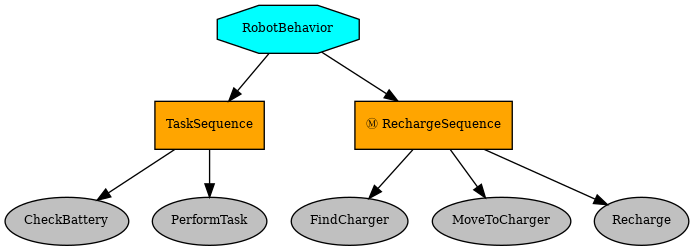

[ INFO] CheckBattery         : Battery level: 13%
[ INFO] FindCharger          : Searching for charging station...
[ INFO] MoveToCharger        : Moving to charging station...
[o] RobotBehavior [*]
    [-] TaskSequence [✕]
        --> CheckBattery [✕]
        --> PerformTask [-]
    {-} RechargeSequence [*]
        --> FindCharger [✓]
        --> MoveToCharger [*]
        --> Recharge [-]

Blackboard Data
    /bar          : bar
    /battery_level: 3
    /charger_found: True
    /dude         : bob
    /dudette      : -
    /foo          : bar
    /key          : -

[ INFO] CheckBattery         : Battery level: 3%
[ INFO] MoveToCharger        : Moving to charging station...
[o] RobotBehavior [*]
    [-] TaskSequence [✕]
        --> CheckBattery [✕]
        --> PerformTask [-]
    {-} RechargeSequence [*]
        --> FindCharger [✓]
        --> MoveToCharger [*]
        --> Recharge [-]

Blackboard Data
    /bar          : bar
    /battery_level: 0
    /charger_found: True
    /dude    

In [ ]:
class CheckBatteryLevel(py_trees.behaviour.Behaviour):
    def __init__(self, name="CheckBattery", threshold=30):
        super(CheckBatteryLevel, self).__init__(name)
        self.threshold = threshold
        
        # Define blackboard client with explicit permissions
        self.blackboard = self.attach_blackboard_client()
        self.blackboard.register_key(key="battery_level", access=py_trees.common.Access.READ)
        self.blackboard.register_key(key="battery_level", access=py_trees.common.Access.WRITE)
        
        # Initialize battery level if not set
        if not self.blackboard.exists('battery_level'):
            self.blackboard.set('battery_level', 75)

    def update(self):
        battery_level = self.blackboard.get('battery_level')
        self.logger.info(f"Battery level: {battery_level}%")
        
        # Decrease battery by 5-15% each time
        battery_level -= 10
        battery_level = max(0, battery_level)  # Don't go below 0
        self.blackboard.set('battery_level', battery_level)
        
        if battery_level <= self.threshold:
            return py_trees.common.Status.FAILURE  # Battery low
        else:
            return py_trees.common.Status.SUCCESS  # Battery OK

class FindChargingStation(py_trees.behaviour.Behaviour):
    def __init__(self, name="FindCharger"):
        super(FindChargingStation, self).__init__(name)
        
        # Define blackboard client with explicit permissions
        self.blackboard = self.attach_blackboard_client()
        self.blackboard.register_key(key="charger_found", access=py_trees.common.Access.WRITE)
    
    def update(self):
        self.logger.info("Searching for charging station...")
        # Simulate finding the charging station
        self.blackboard.set('charger_found', True)
        return py_trees.common.Status.SUCCESS

class MoveToChargingStation(py_trees.behaviour.Behaviour):
    def __init__(self, name="MoveToCharger", duration=1):
        super(MoveToChargingStation, self).__init__(name)
        self.duration = duration
        self.start_time = None
        
        # Define blackboard client with explicit permissions
        self.blackboard = self.attach_blackboard_client()
        self.blackboard.register_key(key="charger_found", access=py_trees.common.Access.READ)
    
    def initialise(self):
        self.start_time = time.time()
    
    def update(self):
        if not self.blackboard.get('charger_found'):
            self.logger.info("No charging station found!")
            return py_trees.common.Status.FAILURE
        
        if time.time() - self.start_time > self.duration:
            self.logger.info("Arrived at charging station")
            return py_trees.common.Status.SUCCESS
        else:
            self.logger.info("Moving to charging station...")
            return py_trees.common.Status.RUNNING

class Recharge(py_trees.behaviour.Behaviour):
    def __init__(self, name="Recharge"):
        super(Recharge, self).__init__(name)
        
        # Define blackboard client with explicit permissions
        self.blackboard = self.attach_blackboard_client()
        self.blackboard.register_key(key="battery_level", access=py_trees.common.Access.READ)
        self.blackboard.register_key(key="battery_level", access=py_trees.common.Access.WRITE)
    
    def update(self):
        level = self.blackboard.get('battery_level')
        if level > 90:
            self.logger.info("Fully recharged!")
            self.blackboard.set('battery_level', level)
            return py_trees.common.Status.SUCCESS
        else:
            current_level = self.blackboard.get('battery_level')
            # Increase battery by 10% each update
            new_level = current_level + 10
            self.blackboard.set('battery_level', new_level)
            self.logger.info(f"Recharging... Battery level: {new_level}%")
            return py_trees.common.Status.RUNNING

class PerformTask(py_trees.behaviour.Behaviour):
    def __init__(self, name="PerformTask"):
        super(PerformTask, self).__init__(name)
    
    def update(self):
        self.logger.info("Performing the main task!")
        return py_trees.common.Status.SUCCESS

root = py_trees.composites.Selector("RobotBehavior", memory=False)

task_sequence = py_trees.composites.Sequence("TaskSequence", memory=False)
task_sequence.add_children([
    CheckBatteryLevel(threshold=30),
    PerformTask()
])

recharge_sequence = py_trees.composites.Sequence("RechargeSequence", memory=True)
recharge_sequence.add_children([
    FindChargingStation(),
    MoveToChargingStation(duration=1),
    Recharge()
])

# The selector will try the task first, but if battery is low (task fails),
# it will try to recharge instead
root.add_children([
    task_sequence,
    recharge_sequence
])

behaviour_tree = py_trees.trees.BehaviourTree(root=root)

print(py_trees.display.ascii_tree(root))

draw_tree(root)

def post_tick_handler(tree):
    print_tree(tree)
    print(py_trees.display.unicode_blackboard())


try:
    behaviour_tree.tick_tock(
        period_ms=500,
        number_of_iterations=10,
        pre_tick_handler=None,
        post_tick_handler=post_tick_handler,
    )

except KeyboardInterrupt:
    behaviour_tree.interrupt()